# Proglearn: Scene Segmentation (Neural Network)

Neuro Data Design I: Fall 2021

This tutorial provides a walkthrough for applying a neural network (Unet architecture) for scene segmentation. Following this, an attempt was made to apply this same architecture to the Proglearn framework.

In [1]:
"""
Neural network functions for scene segmentation. Based off of 

"""
from keras import layers
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, concatenate, Conv1D, Conv1DTranspose, MaxPool1D
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.transformers import (
    NeuralClassificationTransformer,
)
from keras import Model
from proglearn.voters import KNNClassificationVoter

from proglearn.network import LifelongClassificationNetwork

from tensorflow.keras.backend import clear_session

from nn import *


In [2]:
import numpy as np
import tensorflow as tf
import keras
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.color import rgb2gray
from google.colab import drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocessing

Images from the ADE20K consistency set are used in this exercise, which contains 64 images where different objects in the scene are segmented into different colors. However, between different images, the same objects do not necessarily share the same color. As a result, the preprocessing step not only involves separating the data into train and test sets but also relabeling pixel values from color values to class values.

In [3]:
# RUN THIS CELL TO LOAD DATA AND SORT INTO SAMPLES AND LABELS

# CHANGE PATH TO ROOT DIRECTORY OF WHERE YOUR DATA IS LOCATED
# e.g. ./projects/
dataloc = '/content/drive/MyDrive/'

# don't change this
datadir = dataloc + 'ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/'
imgkeys = [im.split('_seg')[0] for im in os.listdir(datadir) if '_seg' in im]
lblpaths = [datadir+im for im in os.listdir(datadir) if '_seg' in im]
imgpaths = [datadir+im for im in os.listdir(datadir) if '.jpg' in im and im.split('.jpg')[0] in imgkeys]


imgpaths.sort()
lblpaths.sort()
print('Total # of images =', len(imgpaths))
print('Total # of labels =', len(lblpaths))
imgpaths[:5], lblpaths[:5]

Total # of images = 64
Total # of labels = 64


(['/content/drive/MyDrive/ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001001.jpg',
  '/content/drive/MyDrive/ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001005.jpg',
  '/content/drive/MyDrive/ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001015.jpg',
  '/content/drive/MyDrive/ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001034.jpg',
  '/content/drive/MyDrive/ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001054.jpg'],
 ['/content/drive/MyDrive/ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001001_seg.png',
  '/content/drive/MyDrive/ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001005_seg.png',
  '/content/drive/MyDrive/ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001015_seg.png',
  '/content

In [4]:
def load_images(flatten_imgs=False):
    if flatten_imgs:
        X = np.array([cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE).flatten() for imgpath in imgpaths])
        Y = np.array([cv2.imread(lblpath, cv2.IMREAD_GRAYSCALE).flatten() for lblpath in lblpaths])
    else:
        X = np.array([cv2.imread(imgpath) for imgpath in imgpaths])
        Y = np.array([cv2.imread(lblpath) for lblpath in lblpaths])
    return X,Y

In [5]:
def load_image(image, mask):
  input_image = tf.image.resize(image, (256, 256), method='nearest')
  input_image = (input_image - tf.reduce_min(input_image)) / (tf.reduce_max(input_image) - tf.reduce_min(input_image)) * 255
  input_mask = tf.image.resize(mask, (256, 256), method='nearest')
  input_mask = (input_mask - tf.reduce_min(input_mask)) / (tf.reduce_max(input_mask) - tf.reduce_min(input_mask)) * 252
  return input_image, input_mask

Extract images and reshape them into 256x256x3 tensors.

In [6]:
# change flatten_imgs to True or False depending on how you want to load the data
flatten_imgs = False
X, Y = load_images(flatten_imgs)
X_data = np.zeros((X.shape[0], 256, 256, 3))
Y_data = np.zeros((Y.shape[0], 256, 256, 3))
for i, (x, y) in enumerate(zip(X, Y)):
    X_data[i], Y_data[i] = tf.cast(load_image(x,y), tf.int16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


Hyper parameters for training:

- `n_epoch`: number of training epochs
- `n_batch_items`: number of training points per batch
- `n_classes`: number of classes in the data set (determined by finding number of unique RGB color values across all images)

In [7]:
# hyperparameters

n_epoch = 10
n_batch_items = 3
n_classes = len(np.unique(Y_data.reshape(-1, 3), axis = 0))

print(X_data[0].shape)
print(n_classes)

Y_data_new = np.zeros((Y_data.shape[0], 256, 256, 1))

# relabeling
for i, j in zip(np.unique(Y_data.reshape(-1, 3), axis = 0), np.arange(n_classes)):
    where = (Y_data == i).all(axis=3)
    Y_data_new[where] = j

(256, 256, 3)
1460


In [8]:
input_layer = keras.Input(shape = X_data[0].shape)
print(input_layer.shape)
model = unet(input_layer, n_classes)

(None, 256, 256, 3)


## Neural Network

A Unet neural network is constructed, which is a type of neural network used in image segmentation commonly used in biomedical applications. This network uses the Adam optimizer and computes loss via Sparse Categorical Crossentropy. An aditional metric called the Dice score iis also computed, which calculates the similarity between the predicted segmentation and the ground truth segmentation.

In [9]:
# dice score
def dice(y_true, y_pred):
    intersection = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
    return (intersection * 2.0) / tf.cast((tf.size(y_true) + tf.size(y_pred)), tf.float32)

In [10]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy', dice])

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data_new, test_size = 16)
print(X_train.min())
print(model.input_shape)
print(model.output_shape)
print(model.summary())

0.0
(None, 256, 256, 3)
(None, 256, 256, 1460)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )              

### Training

In [12]:
model_history = model.fit(x = X_train, y = Y_train, epochs=n_epoch, batch_size = n_batch_items, verbose=1)


Epoch 1/100
12/12 [==============================] - 30s 1s/step - loss: 7.6240 - accuracy: 0.0017 - dice: 0.0000e+00
Epoch 2/100
12/12 [==============================] - 16s 1s/step - loss: 7.1939 - accuracy: 0.0084 - dice: 0.0000e+00
Epoch 3/100
12/12 [==============================] - 16s 1s/step - loss: 6.8673 - accuracy: 0.0166 - dice: 0.0000e+00
Epoch 4/100
12/12 [==============================] - 16s 1s/step - loss: 6.4382 - accuracy: 0.0152 - dice: 0.0000e+00
Epoch 5/100
12/12 [==============================] - 16s 1s/step - loss: 6.1807 - accuracy: 0.0074 - dice: 0.0000e+00
Epoch 6/100
12/12 [==============================] - 16s 1s/step - loss: 6.0301 - accuracy: 0.0189 - dice: 0.0000e+00
Epoch 7/100
12/12 [==============================] - 15s 1s/step - loss: 5.9019 - accuracy: 0.0199 - dice: 0.0000e+00
Epoch 8/100
12/12 [==============================] - 15s 1s/step - loss: 5.8411 - accuracy: 0.0206 - dice: 0.0000e+00
Epoch 9/100
12/12 [==============================] - 15s

In [13]:
# from google.colab import files

# model.save("model")
# files.download("model")

In [14]:
# model = keras.model.load_model("model")

### Testing

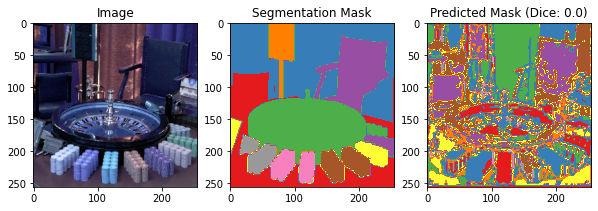

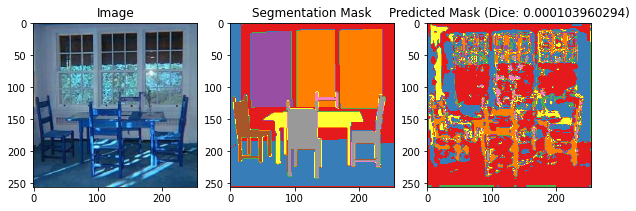

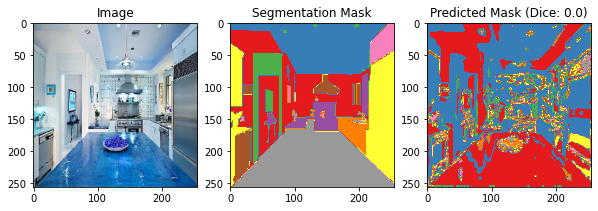

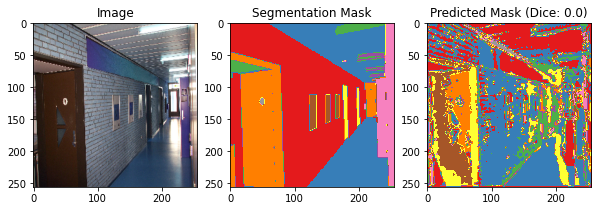

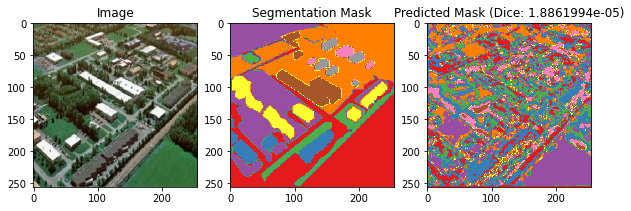

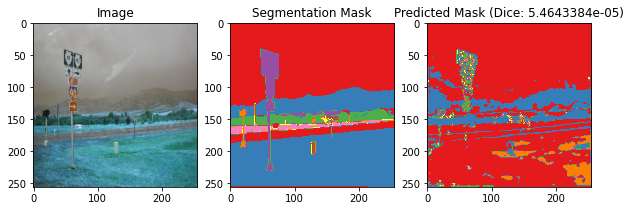

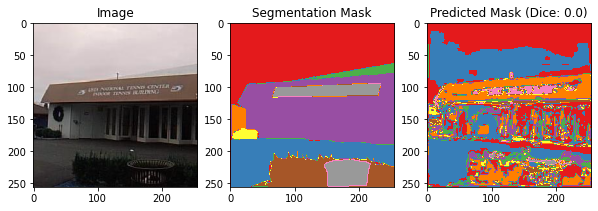

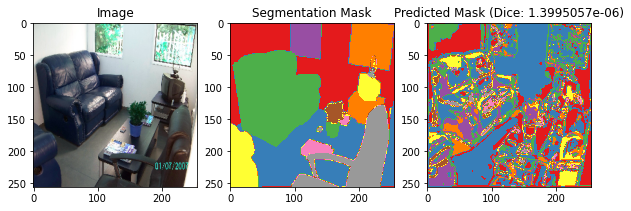

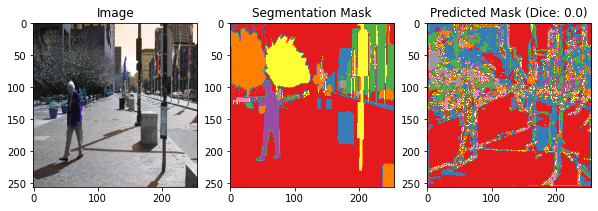

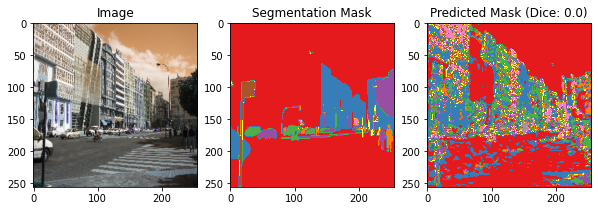

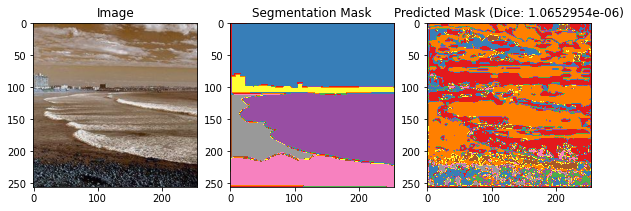

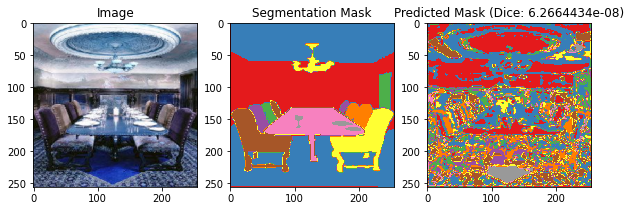

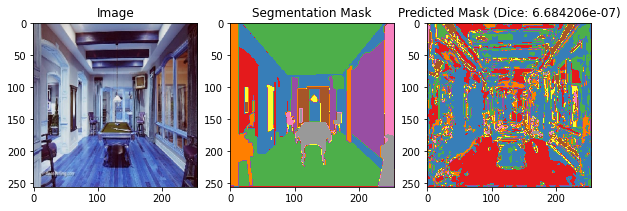

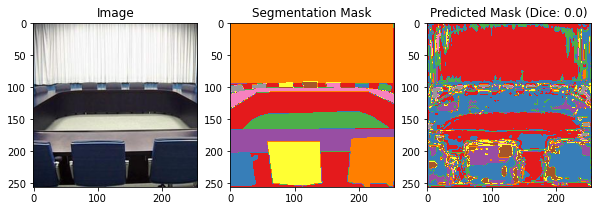

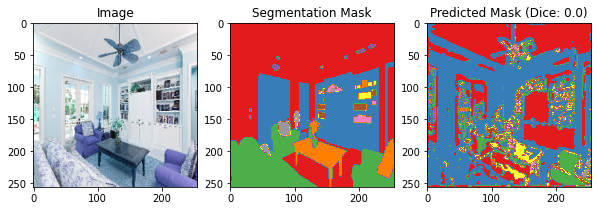

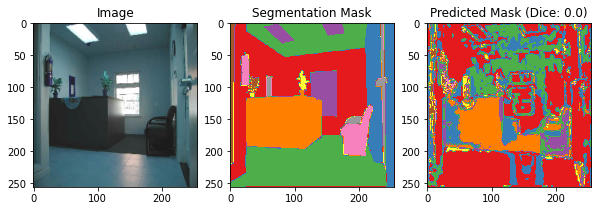

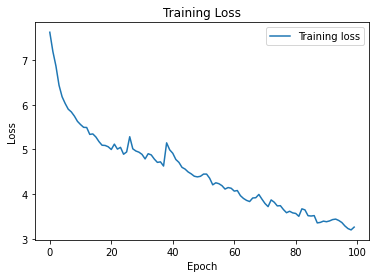

Overall Accuracy: 1.1291347385533612e-05


In [16]:
dices = np.zeros(len(X_test))
for i in np.arange(len(X_test)):
    pred = model.predict(tf.convert_to_tensor([X_test[i]]))
    score = dice(Y_test[i], pred)
    plt.figure(figsize=(10, 30))
    plt.subplot(1, 3, 1)
    plt.imshow(tf.cast(X_test[i], tf.int32))
    plt.title("Image")
    plt.subplot(1,3,2)
    plt.imshow(Y_test[i].reshape(256,256), cmap = "Set1")
    plt.title("Segmentation Mask")
    plt.subplot(1,3,3)
    plt.imshow(np.argmax(pred, axis=3).reshape(256,256), cmap= "Set1")
    plt.title("Predicted Mask (Dice: " + str(score.numpy()) + ")")
    dices[i] = score.numpy()
plt.figure()
plt.plot(model_history.epoch, model_history.history['loss'], label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Overall Accuracy: " + str(np.mean(dices)))

## Proglearn LifelongClassificationNetwork

An attempt at implementing the previously used procedure for image segmentation was made in the Proglearn framework. This was done by passing a Unet network into the `LifelongClassificationNetwork` constructor. This is initially successful, but attempting to add a task to the network produces an error as the use of the `check_X_y()` scikit-learn function will produce an error if the `y` array is not one dimensional. As such, Progleanr in its current state is only compatible with prediction tasks where the output is one-dimensional, making it incompatible with the image segmentation task whose output is two-dimensional.

In [ ]:
from proglearn import LifelongClassificationNetwork

prognet = LifelongClassificationNetwork(
    network = unet_network(input_layer, num_classes=n_classes)
)

prognet.add_task(X_train, Y_train, task_id=0)

# test prediction on a sample image
prediction = progtree.predict(X_test, task_id = 0)
prediction_proba = progtree.predict_proba(X_test, task_id = 0)